<a href="https://colab.research.google.com/github/harshalk612/DATA6100/blob/main/NeuralNetworks/MNIST_example_with_blanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import jax
import time
from tqdm import tqdm

# What is this?

This notebook is based on the JAX training for MNIST and builds up a simple fully connected neural network (aka Multi-Layer-Perceptron MLP) starting from ordinary linear regression, and then logistic regression to build up the intuition for how it works.

#Load MNIST Dataset

In [2]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [3]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())

batch_size = 128
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



## Train and test sets

In [4]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = np.array(mnist_dataset.train_labels)

N_train = 10000
train_images = train_images[0:N_train,:] #get a subset of the data
train_labels = train_labels[0:N_train]


# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = np.array(mnist_dataset_test.test_labels)


N_test = 10000
test_images = test_images[0:N_test,:] #get a subset of the data
test_labels = test_labels[0:N_test]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Plotting examples of MNIST dataset

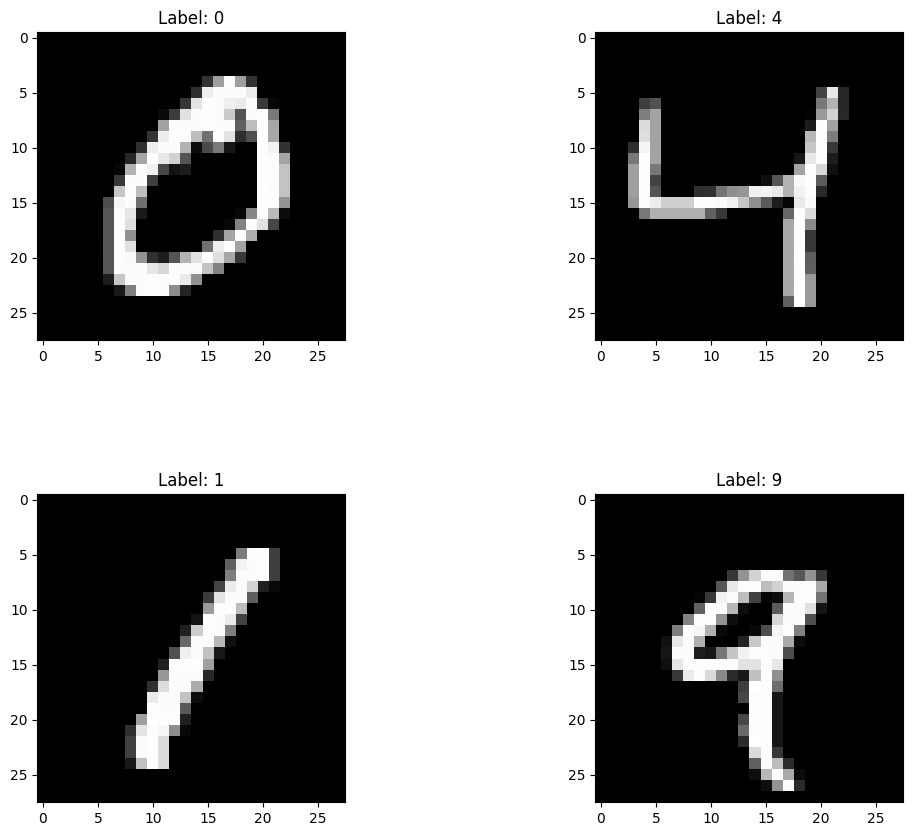

In [5]:
import matplotlib.pyplot as plt

def plot_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 10))

  #plotting images from the training set
  for i in range(1, n_grid**2 + 1):
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.title(f"Label: {my_labels[i]}")

    img = train_images[i].reshape((28,28))
    plt.imshow(img, cmap='gray')

plot_MNIST_train_examples(train_labels)

# Linear Regression (LinR)

We think of linear regression as a [784 by 1] graph.

## Generate random starting paramaters

In [6]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale=1e-2):
  keys = jax.random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

key = jax.random.PRNGKey(int(time.time()))

In [7]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

## Create our function and our loss function

In [8]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def LinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  ##### FILL IN THE OUTPUT #####
  LinR_Output = (jnp.dot(w, x) + b)[0]
  ##############################
  return LinR_Output

print("Lin Reg on 1st training example:")
print(LinR(params,train_images[0]))

Lin Reg on 1st training example:
16.245684


In [9]:

#### FILL IN#####
#### Make a version of LinR that runs on multple inputs at once ###
#### Hint: Use the magic of JAX!
batched_LinR = jax.vmap(LinR, in_axes = (None, 0)) ###???
################

print("Lin Reg on all training example:")
print(batched_LinR(params,train_images))

Lin Reg on all training example:
[ 16.245684  -4.779806  29.907522 ...  15.021154 -19.486032   7.671015]


In [11]:
def MSE_loss_for_LinR(params,images,target):
  preds = batched_LinR(params, images)

  ### FILL IN THE FORMULA FOR THE MSE
  MSE = jnp.mean((preds - target) ** 2) ###

  return MSE

print("MSE loss of LinR on training set:")
print(MSE_loss_for_LinR(params,train_images,train_labels))
print(jnp.sqrt(MSE_loss_for_LinR(params,train_images,train_labels)))

MSE loss of LinR on training set:
292.66498
17.107454


# Training loop using gradient descent

Here we will repeatedely update the "params" by using gradient descent

In [14]:
import time

def training_loop(loss_func, acc_func=None, num_epochs = 2, step_size = 0.01):
  global params
  saved_results = []
  for epoch in range(1,num_epochs+1):

      print(f"---Epoch #{epoch}---")
      #Update the weights by gradient descent!
      start_time = time.time()
      for x, y in tqdm(training_generator):
          # This loop will create mini-batches of (x,y) paris to train on
          # The batch size is set as part of the training generator
          # Running through all the examples is called an ''epoch''

          ### FILL IN THE FORMULA FOR THE GRADIENT
          ### Hint: Use JAX magic!!
          grads = jax.grad(loss_func)(params,  x, y) ###

          #FILL IN THE FORMULA FOR THE W and B UPDATES IN TERMS OF THE PARAMS
          params = [( w - step_size * dw , b - step_size * db)
                    for (w, b), (dw, db) in zip(params, grads)]

      #### A bunch of bookeeping here to print and record the infrmation ####
      #Print and record stats of this epoch
      if acc_func != None:
        train_acc = acc_func(params, train_images, train_labels)
        test_acc = acc_func(params, test_images, test_labels)

      train_CE_loss = loss_func(params, train_images, train_labels)
      test_CE_loss = loss_func(params, test_images, test_labels)

      results_dict = {'epoch': epoch,
              'train_loss': np.copy(train_CE_loss).item(),
              'test_loss': np.copy(test_CE_loss).item(),
              }

      if acc_func != None:
        results_dict['train_acc'] = np.copy(train_acc).item()
        results_dict['test_acc'] = np.copy(test_acc).item()

      saved_results += [results_dict]

      epoch_time = time.time() - start_time
      print(f"---Time: {epoch_time:0.2f} sec---")
      if acc_func != None:
        print(f"  Train  acc: {train_acc:0.4f}")
        print(f"  Test   acc: {test_acc:0.4f}")
      print(f"  Train loss: {train_CE_loss:0.4f}")
      print(f"  Test  loss: {test_CE_loss:0.4f}")


  return saved_results

In [16]:
#Train the network!
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_LinR,num_epochs=2,step_size = 0.00000001)

---Epoch #1---


100%|██████████| 469/469 [00:08<00:00, 53.74it/s]


---Time: 8.75 sec---
  Train loss: 129.2191
  Test  loss: 128.8711
---Epoch #2---


100%|██████████| 469/469 [00:08<00:00, 54.51it/s]

---Time: 8.63 sec---
  Train loss: 91.3709
  Test  loss: 90.9220


[{'epoch': 1,
  'train_loss': 129.2191162109375,
  'test_loss': 128.87112426757812},
 {'epoch': 2, 'train_loss': 91.37085723876953, 'test_loss': 90.92195129394531}]

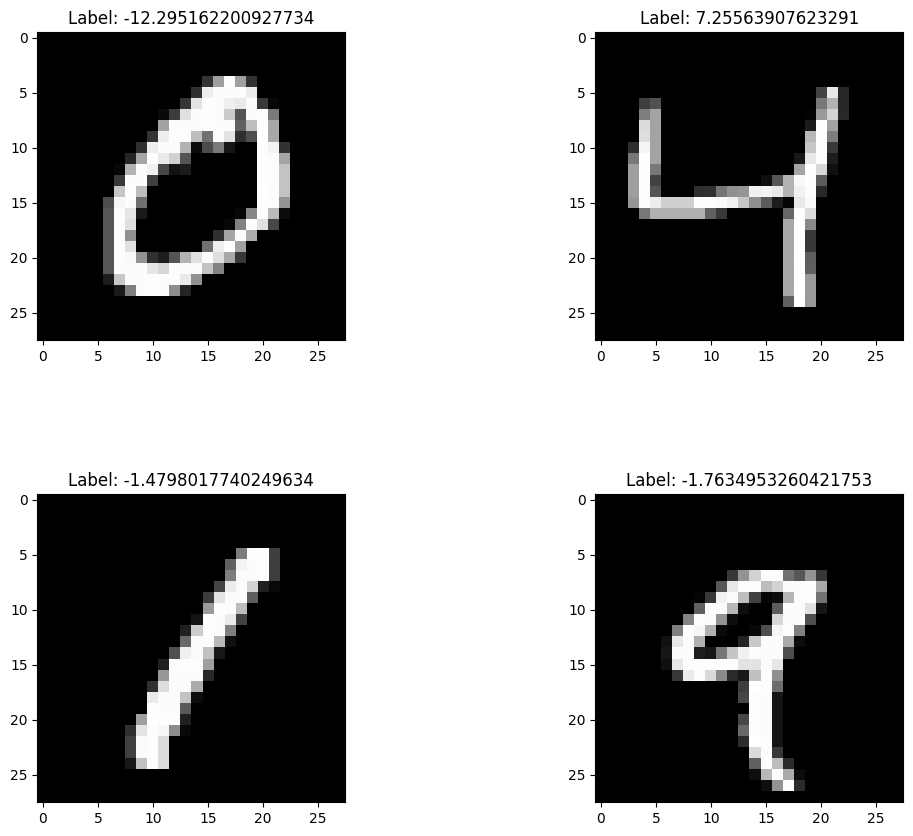

In [17]:
LinR_labels = batched_LinR(params, train_images)
plot_MNIST_train_examples(LinR_labels)

# Non-linear but still regression (NonLinR)

In [18]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def sigmoid(x):
  #Fill in the sigmoid function to "crunch down" (-\infty, \infty) to (0,9)
  return jnp.exp(x)/(1+jnp.exp(x))


def NonLinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  #### FILL IN A VERSION
  output_between_0_and_9 = 9 * sigmoid(jnp.dot(w, x) + b) [0]###
  ####

  return output_between_0_and_9 ###


print("NonLinR on a single example:")
print(NonLinR(params,train_images[0]))

batched_NonLinR = jax.vmap(NonLinR, in_axes=(None, 0))
print("NonLinR on a all examples:")
print(batched_NonLinR(params,train_images))

def MSE_loss_for_NonLinR(params,images,target):
  preds = batched_NonLinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE of train set for NonLin R")
print(MSE_loss_for_NonLinR(params,train_images,train_labels))

NonLinR on a single example:
8.999999
NonLinR on a all examples:
[8.9999990e+00 7.4949250e-02 9.0000000e+00 ... 8.9999971e+00 3.1014594e-08
 8.9958067e+00]
MSE of train set for NonLin R
29.081274


In [26]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key, scale = 0.0001)
training_loop(MSE_loss_for_NonLinR,step_size = 0.0000001)

---Epoch #1---


100%|██████████| 469/469 [00:12<00:00, 38.54it/s]


---Time: 12.21 sec---
  Train loss: 3.4049
  Test  loss: 3.3885
---Epoch #2---


100%|██████████| 469/469 [00:11<00:00, 41.49it/s]

---Time: 11.33 sec---
  Train loss: 3.3026
  Test  loss: 3.3030


[{'epoch': 1, 'train_loss': 3.404881238937378, 'test_loss': 3.388489007949829},
 {'epoch': 2,
  'train_loss': 3.302598237991333,
  'test_loss': 3.3029634952545166}]

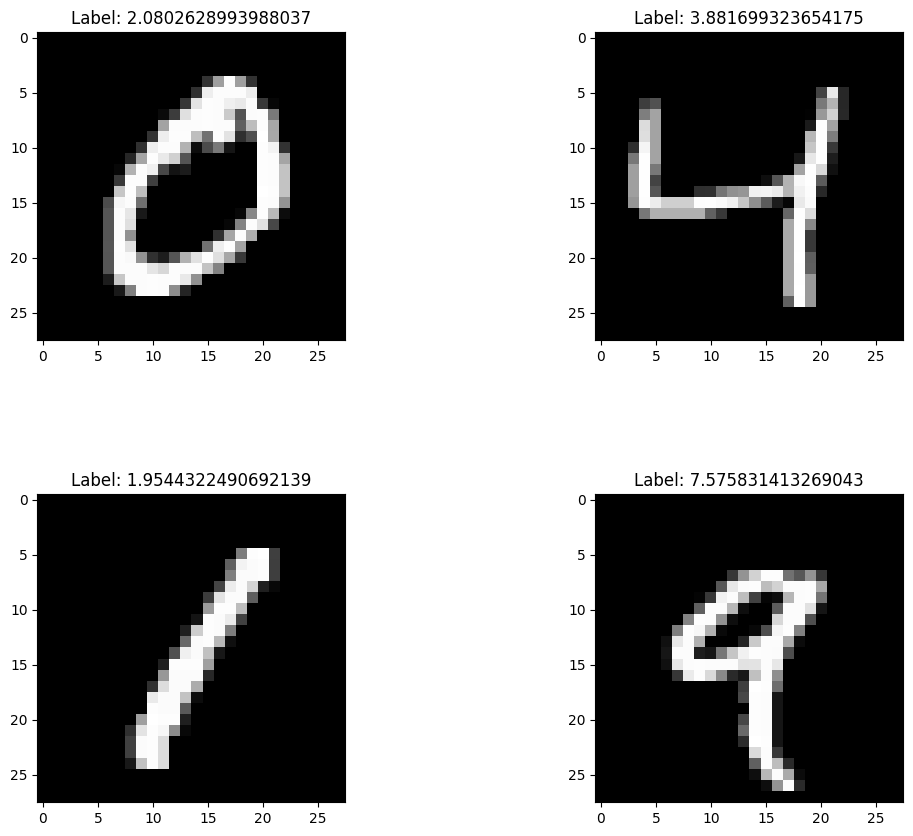

In [27]:
NonLinR_labels = batched_NonLinR(params, train_images)
plot_MNIST_train_examples(NonLinR_labels)

# Logisitic Regression (LogiR)

In [ ]:
#Initialize Parameters

#Fill in the SIZE of the output layer for logisitic regression
#Hint: How does logistic regression translate between output
# and the class probabilities when there are more than 2 classes?
output_size = None
layer_sizes = [784, output_size]
params = init_network_params(layer_sizes, key)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def LogiR_logP(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  ##### Fill in the formula for the logits
  logits = jnp.dot(w, x) + b

  #This just makes it so that the logits are not too big
  # (Big logits can cause numerical issues like nan to appear)
  logits_max_zero = logits - jnp.max(logits)

  #### Fill in the formula to get the log(probability) using the logits
  probabilities = jnp.exp(logits_max_zero) / jnp.sum(jnp.exp(logits_max_zero))

  log_prob = logits_max_zero - jnp.log(jnp.sum(jnp.exp(logits_max_zero))) # DIVIDE COMES AS (-1)
  return log_prob

print("LogiR on one example:")
print(LogiR_logP(params, train_images[0]))

batched_LogiR_logP = jax.vmap(LogiR_logP, in_axes=(None, 0))

print("LogiR on all examples:")
print(batched_LogiR_logP(params, train_images))



def CE_loss_for_LogiR(params,images,target):
  preds = batched_LogiR_logP(params, images)

  #Instead of a target being from 0 to 9, we need to convert this to a vector
  # Fill in how to do it!
  target_as_vector = None

  #FILL IN THE FORMULA FOR CROSS ENTROPY LOSS
  CE_loss = None

  return CE_loss

print("CE loss of LogiR on all example:")
print(CE_loss_for_LogiR(params,train_images,train_labels))

LogiR on one example:
[-24.901382 -62.914238   0.       -20.9617   -26.477444 -95.15152
 -41.246334 -48.078487 -68.92207  -65.76706 ]
LogiR on all examples:
[[-24.901396   -62.914253     0.         ... -48.078506   -68.92209
  -65.76707   ]
 [-89.63713    -92.17103    -21.78653    ... -45.962914   -91.0006
  -73.108086  ]
 [ -6.4286156   -2.2328708  -10.15359    ...  -0.11768607  -6.1431417
  -32.07563   ]
 ...
 [ -3.3975265  -30.151514   -26.50848    ... -13.721768   -71.722115
  -67.79132   ]
 [ -9.473701   -21.997929    -8.660935   ...  -1.1280038   -6.975233
   -9.59648   ]
 [-54.565536   -37.89062    -46.814037   ...  -7.2396     -34.04228
  -42.529484  ]]
CE loss of LogiR on all example:
3.7324789


In [ ]:
layer_sizes = [784, 10]
params = init_network_params(layer_sizes, key)

def top1_acc_LogiR(params, images, target_class):
  #Fill in how to get the prediction from the LogiR function
  predicted_class = None
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_LogiR,top1_acc_LogiR,num_epochs=2,step_size = 0.01)

---Epoch 1 in 10.69 sec---
  Train  acc: 0.8501
  Test   acc: 0.8411
  Train loss: 2.1198
  Test  loss: 2.3387
---Epoch 2 in 9.64 sec---
  Train  acc: 0.8817
  Test   acc: 0.8818
  Train loss: 1.1986
  Test  loss: 1.2464


[{'epoch': 1,
  'train_loss': 2.1197545528411865,
  'test_loss': 2.3387084007263184,
  'train_acc': 0.8500999808311462,
  'test_acc': 0.8410999774932861},
 {'epoch': 2,
  'train_loss': 1.1985687017440796,
  'test_loss': 1.2463773488998413,
  'train_acc': 0.8816999793052673,
  'test_acc': 0.8817999958992004}]

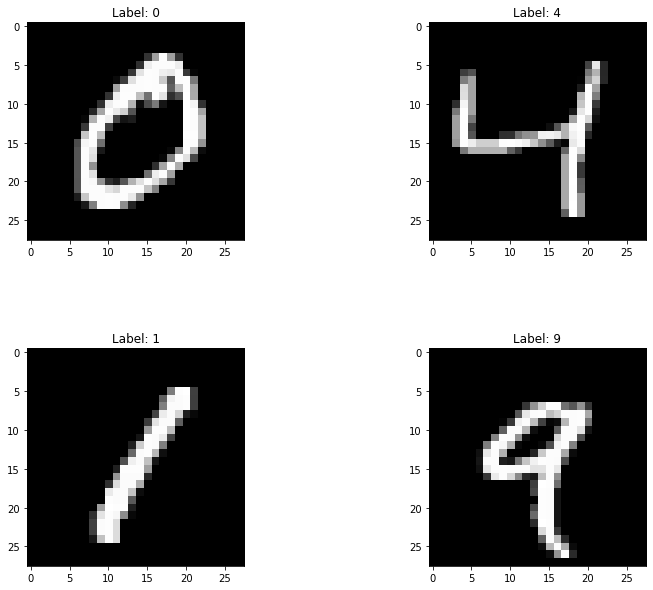

In [ ]:
LogiR_labels = batched_LogiR_logP(params, train_images)
plot_MNIST_train_examples(jnp.argmax(LogiR_labels,axis=1))

## Multi-layer perceptron with cross entropy loss (MLP)

In [ ]:
#Lets start by making a MLP (aka "a fully connected nerual network")
# with one hidden layer
# FILL IN what layer_sizes should be here
layer_sizes = None


params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  #We will use the rele non-liearity for our nerual network
  return None #


def MLP_logP(params, image):
    # per-example predictions
    # Returns the log probability of each class

    x = image
    # first layer is feedforward
    w, b = params[0]

    #Fill in the formula for the first layer
    x = None
    x_transformed = None #Apply a non-linear transformation to x

    for w, b in params[1:-1]: #This loops through all the hidden layers
        # Fill in the formula to be applied at all the hidden layers
        x = None
        x_transformed = None

    final_w, final_b = params[-1]  #This is the last layer
    #Fill in the formula for the logits
    logits = None
    logits_max_zero = logits - jnp.max(logits)

    #Fill in the formula for the log(prob) using the logits
    logP = None

    return logP

print("MLP logP on a single examples")
print(MLP_logP(params, train_images[0]))

MLP logP on a single examples
[-14.982776   -0.3782405 -15.621546  -13.7279215  -4.9733896 -13.424351
 -20.063177   -2.2887373  -1.5889996  -5.9964747]


In [ ]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_MLP_logP = jax.vmap(MLP_logP, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
print("MLP logP on all examples")
batched_preds = batched_MLP_logP(params, train_images)
print(batched_preds)

MLP logP on all examples
[[-1.49827719e+01 -3.78241450e-01 -1.56215448e+01 ... -2.28873634e+00
  -1.58899677e+00 -5.99647713e+00]
 [-2.22175350e+01 -5.48569489e+00 -1.45736256e+01 ... -7.94642512e-03
  -9.85297394e+00 -5.59515381e+00]
 [-4.07513952e+00 -4.65694427e+00 -1.55901327e+01 ... -9.54575920e+00
  -3.59039158e-02 -8.66181278e+00]
 ...
 [-2.40175557e+00 -6.19331181e-01 -1.66161785e+01 ... -7.82844400e+00
  -1.40210748e+00 -3.89843607e+00]
 [-1.23611546e+00 -7.32741785e+00 -1.40732861e+01 ... -1.43470745e+01
  -1.06515627e+01 -4.08330154e+00]
 [-6.15037870e+00 -8.16275406e+00 -1.72831287e+01 ... -5.54770380e-02
  -9.91180038e+00 -3.29676580e+00]]


# Loss function

In [ ]:
def CE_loss_for_MLP(params, images, target):
  #This is exactly the same as for Logistic Regression!
  preds = batched_MLP_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot)

print("CE loss for the the MLP")
print(CE_loss_for_MLP(params, train_images, train_labels))


CE loss for the the MLP
1.03355


In [ ]:
layer_sizes = [784, 784, 10]
params = init_network_params(layer_sizes, key)


def top1_acc_MLP(params, images, target_class):
  predicted_class = jnp.argmax(batched_MLP_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_MLP, top1_acc_MLP)

---Epoch 1 in 32.74 sec---
  Train  acc: 0.9270
  Test   acc: 0.9288
  Train loss: 0.0246
  Test  loss: 0.0240
---Epoch 2 in 27.26 sec---
  Train  acc: 0.9456
  Test   acc: 0.9448
  Train loss: 0.0183
  Test  loss: 0.0185


[{'epoch': 1,
  'train_loss': 0.024588339030742645,
  'test_loss': 0.023965951055288315,
  'train_acc': 0.9269999861717224,
  'test_acc': 0.9287999868392944},
 {'epoch': 2,
  'train_loss': 0.018313348293304443,
  'test_loss': 0.01852300763130188,
  'train_acc': 0.9455999732017517,
  'test_acc': 0.9447999596595764}]

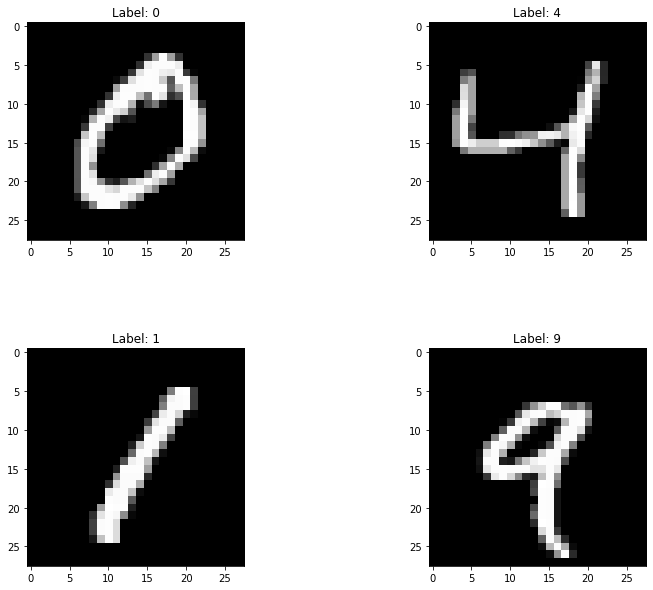

In [ ]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_MNIST_train_examples( MLP_labels)

In [ ]:
def plot_incorrect_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  image_ix = 0
  for i in range(1, n_grid**2 + 1):
    image_ix += 1
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    while train_labels[image_ix] == my_labels[image_ix]: #loop through to find incorrectly labeled examples
      image_ix += 1
    plt.title(f"My Label: {my_labels[image_ix]}, Actual: {train_labels[image_ix]}")
    img = train_images[image_ix].reshape((28,28))
    plt.imshow(img, cmap='gray')

In [ ]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_incorrect_MNIST_train_examples( MLP_labels,n_grid = 3)